# 1.4

## 1.4.1 Spiral Dataset

In [1]:
import numpy as np

def spiral_load_data(seed=1984):
    np.random.seed(seed)
    N = 100  # 클래스당 샘플 수
    DIM = 2  # 데어터 요소 수
    CLS_NUM = 3  # 클래스 수

    x = np.zeros((N*CLS_NUM, DIM))
    t = np.zeros((N*CLS_NUM, CLS_NUM), dtype=np.int)

    for j in range(CLS_NUM):
        for i in range(N): # N*j, N*(j+1)):
            rate = i / N
            radius = 1.0*rate
            theta = j*4.0 + 4.0*rate + np.random.randn()*0.2

            ix = N*j + i
            x[ix] = np.array([radius*np.sin(theta),
                              radius*np.cos(theta)]).flatten()
            t[ix, j] = 1

    return x, t

x (300, 2)
t (300, 3)


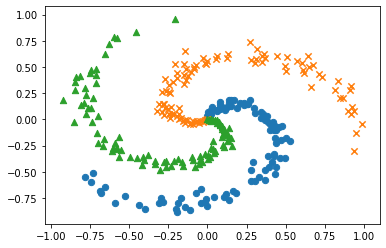

In [2]:
import matplotlib.pyplot as plt

x, t = spiral_load_data()
print('x', x.shape)  # (300, 2)
print('t', t.shape)  # (300, 3)

# 데이터점 플롯
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

## Label (대표 레이블, 0-99, 100-199, 200-299) 3가지 세트

In [3]:
print(t[0])
print(t[100])
print(t[200])

[1 0 0]
[0 1 0]
[0 0 1]


## 1.4.2 Neural network implementation

### 1.3's Layers + Alpha

In [4]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class Affine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        W, b = self.params
        out = np.dot(x, W) + b
        self.x = x
        return out

    def backward(self, dout):
        W, b = self.params
        dx = np.dot(dout, W.T)
        dW = np.dot(self.x.T, dout)
        db = np.sum(dout, axis=0)

        self.grads[0][...] = dW
        self.grads[1][...] = db
        return dx

class Sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx
    
class Softmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        self.out = softmax(x)
        return self.out

    def backward(self, dout):
        dx = self.out * dout
        sumdx = np.sum(dx, axis=1, keepdims=True)
        dx -= self.out * sumdx
        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

In [5]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 가중치와 편향 초기화
        W1 = 0.01 * np.random.randn(I, H)
        b1 = np.zeros(H)
        W2 = 0.01 * np.random.randn(H, O)
        b2 = np.zeros(O)

        # 계층 생성
        self.layers = [
            Affine(W1, b1),
            Sigmoid(),
            Affine(W2, b2)
        ]
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

### Optimzer

In [6]:
class SGD:
    '''
    확률적 경사하강법(Stochastic Gradient Descent)
    '''
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for i in range(len(params)):
            params[i] -= self.lr * grads[i]

### Training Code

| 에폭 1 |  반복 10 / 10 | 손실 1.13
| 에폭 2 |  반복 10 / 10 | 손실 1.13
| 에폭 3 |  반복 10 / 10 | 손실 1.12
| 에폭 4 |  반복 10 / 10 | 손실 1.12
| 에폭 5 |  반복 10 / 10 | 손실 1.11
| 에폭 6 |  반복 10 / 10 | 손실 1.14
| 에폭 7 |  반복 10 / 10 | 손실 1.16
| 에폭 8 |  반복 10 / 10 | 손실 1.11
| 에폭 9 |  반복 10 / 10 | 손실 1.12
| 에폭 10 |  반복 10 / 10 | 손실 1.13
| 에폭 11 |  반복 10 / 10 | 손실 1.12
| 에폭 12 |  반복 10 / 10 | 손실 1.11
| 에폭 13 |  반복 10 / 10 | 손실 1.09
| 에폭 14 |  반복 10 / 10 | 손실 1.08
| 에폭 15 |  반복 10 / 10 | 손실 1.04
| 에폭 16 |  반복 10 / 10 | 손실 1.03
| 에폭 17 |  반복 10 / 10 | 손실 0.96
| 에폭 18 |  반복 10 / 10 | 손실 0.92
| 에폭 19 |  반복 10 / 10 | 손실 0.92
| 에폭 20 |  반복 10 / 10 | 손실 0.87
| 에폭 21 |  반복 10 / 10 | 손실 0.85
| 에폭 22 |  반복 10 / 10 | 손실 0.82
| 에폭 23 |  반복 10 / 10 | 손실 0.79
| 에폭 24 |  반복 10 / 10 | 손실 0.78
| 에폭 25 |  반복 10 / 10 | 손실 0.82
| 에폭 26 |  반복 10 / 10 | 손실 0.78
| 에폭 27 |  반복 10 / 10 | 손실 0.76
| 에폭 28 |  반복 10 / 10 | 손실 0.76
| 에폭 29 |  반복 10 / 10 | 손실 0.78
| 에폭 30 |  반복 10 / 10 | 손실 0.75
| 에폭 31 |  반복 10 / 10 | 손실 0.78
| 에폭 32 |  반복 10 

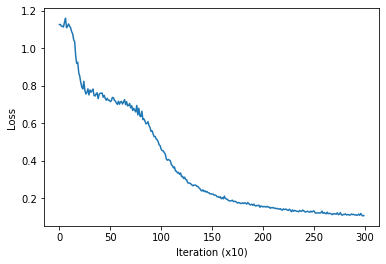

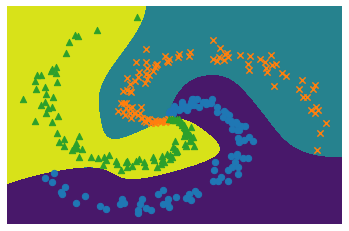

In [10]:
# 하이퍼파라미터 설정
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1.0

# 데이터 읽기, 모델과 옵티마이저 생성
x, t = spiral_load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 학습에 사용하는 변수
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    # 데이터 뒤섞기
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters*batch_size:(iters+1)*batch_size]
        batch_t = t[iters*batch_size:(iters+1)*batch_size]

        # 기울기를 구해 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

        # 정기적으로 학습 경과 출력
        if (iters+1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print('| 에폭 %d |  반복 %d / %d | 손실 %.2f'
                  % (epoch + 1, iters + 1, max_iters, avg_loss))
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0


# 학습 결과 플롯
plt.plot(np.arange(len(loss_list)), loss_list, label='train')
plt.xlabel('Iteration (x10)')
plt.ylabel('Loss')
plt.show()

# 경계 영역 플롯
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# 데이터점 플롯
x, t = spiral_load_data()
N = 100
CLS_NUM = 3
markers = ['o', 'x', '^']
for i in range(CLS_NUM):
    plt.scatter(x[i*N:(i+1)*N, 0], x[i*N:(i+1)*N, 1], s=40, marker=markers[i])
plt.show()

(4323264, 3)
[[ 7.0750414  -6.07991423 -1.0589919 ]
 [ 7.07900866 -6.07605854 -1.06679914]
 [ 7.08296037 -6.07223889 -1.07455478]
 ...
 [-0.21141344  5.13294553 -4.89219269]
 [-0.21039943  5.13274253 -4.89299605]
 [-0.20938711  5.13254678 -4.89380497]]
[0 0 0 ... 1 1 1]
(2047, 2112)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]


(-1.0223506996640548,
 1.0886493003357127,
 -0.9886726617070215,
 1.0573273382929806)

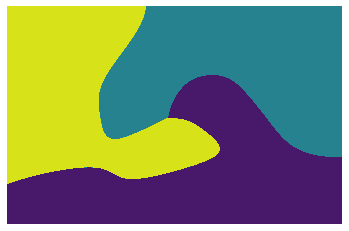

In [18]:
# 경계 영역 플롯
h = 0.001
x_min, x_max = x[:, 0].min() - .1, x[:, 0].max() + .1
y_min, y_max = x[:, 1].min() - .1, x[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
print(score.shape)
print(score)
print(predict_cls)
Z = predict_cls.reshape(xx.shape)
print(Z.shape)
print(Z)
plt.contourf(xx, yy, Z)
plt.axis('off')